# 迁移学习
你在本教程中将学会如何用迁移学习来训练你的神经网络。你可以看[cs231笔记](http://cs231n.github.io/transfer-learning/)学习更多内容。

引用笔记内容：
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

迁移学习的主要两个步骤如下所示：
1. 微调网络：我们用一个预先训练好的网络来初始化网络。剩下的训练过程看起来和普通方法无异。
2. 把神经网络看成固定的特征提取器：这里，我们固定住除了最后全连接层所有层的权重，然后随机初始化最后的全连接层并训练。（但是在一篇关于迁移学习的论文中，不固定住前面层的效果会更好）

In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## 加载数据
我们将用 torchvision 和 torch.utils.data 包来加载数据。

今天我们要训练有一个模型用以区分**蚂蚁**和**蜜蜂**。我们大概有蚂蚁和蜜蜂各 120 张训练图片数据。每一类各有 75 张验证图像数据。一般而言，这么小的数据量很难使得咱们从零开始训练的模型泛化能力强到能够普及到一般情况（即区分训练数据之外的蚂蚁和蜜蜂）。所以，我们应用迁移学习。它能够使我们模型的泛化能力得到较大的提升。

这个数据集是 imagenet 的一个很小的子集。

**注意：**
从[这里](https://download.pytorch.org/tutorial/hymenoptera_data.zip)下载数据并解压到当前目录下。

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 显示一些图片
让我们显示一些图片来理解下数据增强（data augmentations）。

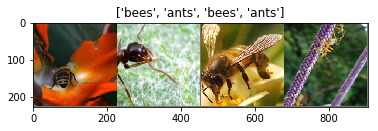

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 训练模型
现在我们写个通用的方法来训练模型。在这里我们将说明：
1. 规划学习率（Scheduling the learning rate）
2. 保存最佳模型（Saving the best model)

在下面的例子中，参数 <font color=red>scheduler</font> 是一个来自 <font color=red>torch</font> LR scheduler 的对象。

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 可视化模型的预测
通用的用于可视化一些图像的预测结果

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 微调神经网络
载入一个与训练过的模型然后随机初始化我们的全连接层。

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/linyuhuan/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [02:18<00:00, 337332.79it/s]


### 训练和评估
接下来的过程如果在 CPU 上训练需要大概 15-25 分钟。在 GPU 上训练应该会少于 1 分钟。

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8774 Acc: 0.6107
val Loss: 0.3833 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4842 Acc: 0.8033
val Loss: 0.6573 Acc: 0.7712

Epoch 2/24
----------
train Loss: 0.7095 Acc: 0.7623
val Loss: 0.4546 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.6249 Acc: 0.7336
val Loss: 0.2764 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4881 Acc: 0.8156
val Loss: 0.3545 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.4597 Acc: 0.8320
val Loss: 0.2714 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4676 Acc: 0.8361
val Loss: 0.3355 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4478 Acc: 0.8443
val Loss: 0.2504 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2709 Acc: 0.8689
val Loss: 0.2402 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2729 Acc: 0.9057
val Loss: 0.2278 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2577 Acc: 0.8852
val Loss: 0.2628 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3012 Acc: 0.8689
val Loss: 0.2314 Acc: 0.9150

Ep

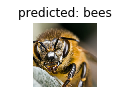

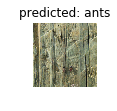

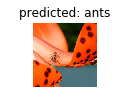

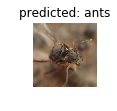

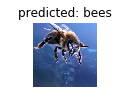

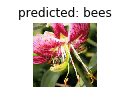

In [28]:
visualize_model(model_ft)

## 将神经网络当成固定的特征提取器
在这里，除了神经网络的最后一层，我们要固定住神经网络的其它层。我们需要设置 <font color=red>requires_grad == False</font> 来固定住参数，使得这些参数在 <font color=red>backward()</font> 过程中不计算梯度。

如果想要了解更多请看[这里](https://pytorch.org/docs/master/notes/autograd.html)

In [29]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 训练和评估
和之前相比，在 CPU 上训练要省将近一半的时间。这是因为网络的大部分梯度是不需要被计算的。但是前向过程还是需要被计算。

In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6758 Acc: 0.6311
val Loss: 0.3287 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5349 Acc: 0.7664
val Loss: 0.1810 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.6181 Acc: 0.7172
val Loss: 0.1633 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.6412 Acc: 0.7828
val Loss: 0.1723 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4033 Acc: 0.8361
val Loss: 0.2272 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.6045 Acc: 0.7705
val Loss: 0.2002 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4037 Acc: 0.8197
val Loss: 0.2176 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4086 Acc: 0.8238
val Loss: 0.1957 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3843 Acc: 0.8484
val Loss: 0.1759 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3571 Acc: 0.8320
val Loss: 0.1739 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3067 Acc: 0.8525
val Loss: 0.1714 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3069 Acc: 0.8770
val Loss: 0.1725 Acc: 0.9542

Ep